### Reading data:

In [159]:
from collections import Set
from enum import Enum
from functools import reduce
from operator import attrgetter

import pandas as pd



dataset = pd.read_csv("/Users/daniilkorolev/Documents/GitHub/3rd-year/ml/labs/01-KNN/solar.csv")
print(dataset)

     largest_spot_size  spot_distribution  Activity  Evolution  \
0                    4                  2         1          2   
1                    4                  2         1          3   
2                    4                  2         1          3   
3                    4                  2         1          3   
4                    0                  2         1          3   
..                 ...                ...       ...        ...   
310                  3                  2         1          2   
311                  3                  2         1          3   
312                  0                  2         1          3   
313                  3                  2         1          3   
314                  2                  0         1          3   

     Previous_24_hour_flare_activity_code  Historically-complex  \
0                                       1                     1   
1                                       1                     1   
2     

### Data understanding:
* sex: sex (1 = male; 0 = female)

* cp: chest pain type
 * Value 1: typical angina
 * Value 2: atypical angina
 * Value 3: non-anginal pain
 * Value 4: asymptomatic

* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

* restecg: resting electrocardiographic results
 * Value 0: normal
 * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
 * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* exang: exercise induced angina (1 = yes; 0 = no)

* slope: the slope of the peak exercise ST segment

* thal:
 * Value 0: normal
 * Value 1: fixed defect
 * Value 2: reversable defect


### Min max normalization for dataset

In [160]:
for feature in dataset:

    if feature == 'class':
        dataset['class'] -= dataset['class'].min()
        continue

    valueColumn = dataset[feature]

    normalizedColumn = (valueColumn - valueColumn.min()) /\
                       (valueColumn.max() - valueColumn.min())

    dataset[feature] = normalizedColumn

print(dataset)

     largest_spot_size  spot_distribution  Activity  Evolution  \
0                  0.8           0.666667       0.0        0.5   
1                  0.8           0.666667       0.0        1.0   
2                  0.8           0.666667       0.0        1.0   
3                  0.8           0.666667       0.0        1.0   
4                  0.0           0.666667       0.0        1.0   
..                 ...                ...       ...        ...   
310                0.6           0.666667       0.0        0.5   
311                0.6           0.666667       0.0        1.0   
312                0.0           0.666667       0.0        1.0   
313                0.6           0.666667       0.0        1.0   
314                0.4           0.000000       0.0        1.0   

     Previous_24_hour_flare_activity_code  Historically-complex  \
0                                     0.0                   0.0   
1                                     0.0                   0.0   
2     

### Get one-hot transformation dataset & naive dataset:

In [161]:
class Object:
    def __init__(self, regressionValue, features, distance=float('inf')):
        self.regressionValue = regressionValue
        self.features = features
        self.distance = distance


one_hot_dataset = []
naive_dataset = []


def normilizeColumn(column):
    minFeatureValue = column.min()
    return column - minFeatureValue

for (i, feature) in enumerate(dataset):

    if feature != 'class':
        one_hot_feature_vectors = normilizeColumn(
            pd.get_dummies(dataset[feature])
        )

        for (j, one_hot_feature_vector) in one_hot_feature_vectors.iterrows():

            if i == 0:
                one_hot_object = Object(regressionValue=0,
                                        features=list(map(float, one_hot_feature_vector.array)))
                one_hot_dataset.append(one_hot_object)

                naive_object = Object(regressionValue=0,
                                      features=[float(dataset[feature][j])])
                naive_dataset.append(naive_object)

            else:
                one_hot_dataset[j].features += list(map(float, one_hot_feature_vector.array))

                naive_dataset[j].features.append(dataset[feature][j])

    else:
        for (j, c) in enumerate(dataset['class']):
            one_hot_dataset[j].regressionValue = int(c)
            naive_dataset[j].regressionValue = int(c)

### Distance & kernel functions:

In [162]:
from math import e, pi, sqrt, cos

def applySubtractThenFunction(function):
    def combinator(pair):
        return function(pair[0] - pair[1])

    return combinator

distanceFunctions = \
    {
        'manhattan': lambda xs, ys: sum(
            map(
                applySubtractThenFunction(abs), zip(xs, ys)
            )
        ),

        'euclidean': lambda xs, ys: sqrt(
            sum(
                map(
                    applySubtractThenFunction(lambda x: x ** 2), zip(xs, ys)
                )
            )
        ),

        'chebyshev': lambda xs, ys: max(
            map(
                applySubtractThenFunction(abs), zip(xs, ys)
            )
        )
    }

kernelFunctions = \
    {
        "uniform": lambda x: 1 / 2 if abs(x) < 1 else 0,

        "triangular": lambda x: 1 - abs(x) if abs(x) < 1 else 0,

        "epanechnikov": lambda x: 3 / 4 * (1 - x ** 2) if abs(x) < 1 else 0,

        "quartic": lambda x: 15 / 16 * ((1 - x ** 2) ** 2) if abs(x) < 1 else 0,

        "triweight": lambda x: 35 / 32 * ((1 - x ** 2) ** 3) if abs(x) < 1 else 0,

        "tricube": lambda x: 70 / 81 * ((1 - abs(x) ** 3) ** 3) if abs(x) < 1 else 0,

        "gaussian": lambda x: 1 / sqrt(2 * pi) * e ** (-1 / 2 * x ** 2),

        "cosine": lambda x: pi / 4 * cos(pi / 2 * x) if abs(x) < 1 else 0,

        "logistic": lambda x: 1 / (2 + e ** x + e ** -x),

        "sigmoid": lambda x: 2 / (pi * (e ** x + e ** -x))
    }

class WindowType(Enum):
    VARIABLE = 'variable'
    FIXED = 'fixed'



### Model class object:

In [163]:
class ValidationDataSet:
    def __init__(self, train_dataset, validationObject):
        self.train_dataset = train_dataset
        self.validationObject = validationObject


class KNNModel:
    def __init__(self,
                 distanceFunction,
                 kernelFunction,
                 windowType):
        self.distanceFunction = distanceFunction
        self.kernelFunction = kernelFunction
        self.windowType = windowType

### Regression function


In [164]:
def meanValue(objs):
    return sum(map(attrgetter('regressionValue'), objs)) / len(objs)


def calculateRegression(objects, kernelFunction, windowValue):

    if windowValue == 0:
        #
        #
        filteredObjects = list(filter(lambda o: o.distance == 0, objects))
        #
        # In case we have no zero-located objects we should calculate mean distance for all objects
        if len(filteredObjects) == 0:
            filteredObjects = objects

        return meanValue(filteredObjects)

    else:

        numerator = sum(
            map(
                lambda o: o.regressionValue * kernelFunction(o.distance / windowValue), objects
            )
        )

        denominator = sum(
            map(
                lambda o: kernelFunction(o.distance / windowValue), objects
            )
        )

        return meanValue(objects) if denominator == 0 else numerator / denominator


### Fill distances for validation objects:

In [165]:
def fill_distances_for_validation_objects(dataset):

    trainDataSets = {
        'manhattan': [],
        'euclidean': [],
        'chebyshev': [],
    }

    for distanceFunctionName in distanceFunctions:

        for (splitIndex, validationObject) in enumerate(dataset):

            train_dataset = dataset[:splitIndex] + dataset[splitIndex + 1:]
            n_train_dataset = []
            
            for o in train_dataset:
                n_train_object = Object(regressionValue=o.regressionValue,
                                        features=o.features,
                                        distance=distanceFunctions[distanceFunctionName](o.features, validationObject.features))
                
                n_train_dataset.append(n_train_object)
                

            trainDataSets[distanceFunctionName].append(
                ValidationDataSet(train_dataset=n_train_dataset,
                                  validationObject=validationObject
                )
            )

    return trainDataSets

### Leave one out validation

In [166]:
def lossFunction(expected, actual):
    # print("Expected = ", expected, "Actual = ", actual)
    return 0 if expected == round(actual) else 1


def leave_one_out_validation(dataset):

    validationDataSets = fill_distances_for_validation_objects(dataset)

    best_loss_value = float('inf')

    for distanceFunctionName in distanceFunctions:
        for kernelFunctionName in kernelFunctions:
            for windowType in WindowType:

                print("\n", distanceFunctionName, kernelFunctionName, windowType, "\n\n")

                neighborsRange = range(1, 150, 5)
                neighborsLoss = dict()

                fixedWindowRange = range(3, 20, 5)
                fixedWindowLoss = dict()


                for neighborIndex in neighborsRange:
                    neighborsLoss[neighborIndex] = 0

                for windowWidth in fixedWindowRange:
                    fixedWindowLoss[windowWidth] = 0


                for validation_dataset in validationDataSets[distanceFunctionName]:

                    expected = validation_dataset.validationObject.regressionValue
                    train_dataset = validation_dataset.train_dataset


                    if windowType == WindowType.VARIABLE:

                        train_dataset = sorted(train_dataset, key=attrgetter('distance'))
                        for neighborIndex in neighborsRange:

                            windowValue = train_dataset[neighborIndex].distance

                            expected = validation_dataset.validationObject.regressionValue
                            actual = calculateRegression(
                                        objects=train_dataset,
                                        kernelFunction=kernelFunctions[kernelFunctionName],
                                        windowValue=windowValue)

                            neighborsLoss[neighborIndex] += lossFunction(expected=expected, actual=actual)


                    else:
                        for windowWidth in fixedWindowRange:

                            actual = calculateRegression(
                                        objects=train_dataset,
                                        kernelFunction=kernelFunctions[kernelFunctionName],
                                        windowValue=windowWidth)

                            fixedWindowLoss[windowWidth] += lossFunction(expected=expected, actual=actual)

                if windowType == WindowType.VARIABLE:
                    for loss in neighborsLoss:
                        if neighborsLoss[loss] < best_loss_value:
                            best_loss_value = neighborsLoss[loss]
                        print("Variable window, best neighbor value =", loss, "loss: =", neighborsLoss[loss])

                else :
                    for loss in fixedWindowLoss:
                        if fixedWindowLoss[loss] < best_loss_value:
                            best_loss_value = fixedWindowLoss[loss]
                        print("Fixed width: =", loss, "loss: =", fixedWindowLoss[loss])


# leave_one_out_validation(one_hot_dataset)

#### Calculating macro F-measure for (euclidean, quartic, variable)

In [167]:
kernelFunctionName = 'triweight'
distanceFunctionName = 'euclidean'


distinct_classes = set(dataset['class'])
classesNumber = max(distinct_classes) - min(distinct_classes) + 1
print("classes count =", classesNumber)


def f_measure(neighborCount, distanceFunctionName, kernelFunctionName):

    confusionMatrix = [[0 for _ in range(classesNumber)] for _ in range(classesNumber)]

    validationDataSets = fill_distances_for_validation_objects(one_hot_dataset)

    for validationSet in validationDataSets[distanceFunctionName]:

        train_dataset = sorted(validationSet.train_dataset, key=attrgetter('distance'))
        windowValue = train_dataset[neighborCount].distance

        expected = validationSet.validationObject.regressionValue
        actual = calculateRegression(
                                objects=train_dataset,
                                kernelFunction=kernelFunctions[kernelFunctionName],
                                windowValue=windowValue)
 
        confusionMatrix[expected][max(min(classesNumber, round(actual)), 0)] += 1


    def divide(numerator, denominator):
        return 0 if denominator == 0 else numerator / denominator

    elementsCount = sum(map(sum, confusionMatrix))

    predicted = list(map(sum, confusionMatrix))
    actual = list(reduce(lambda acc, row: map(sum, zip(acc, row)), confusionMatrix))

    true_positive = [confusionMatrix[i][i] for i in range(classesNumber)]

    weight_precision = \
        sum(
            [divide(true_positive[i] * actual[i], predicted[i]) for i in range(classesNumber)]
        ) / elementsCount

    weight_recall = sum(true_positive) / elementsCount

    macro_F_measure = divide(2 * weight_precision * weight_recall, weight_precision + weight_recall)

    return macro_F_measure


classes count = 6


#### Drawing graphic



In [168]:
xs = list(range(1, 300))
ys = list(map(lambda x: f_measure(x, distanceFunctionName, kernelFunctionName), xs))


### Drawing graphic


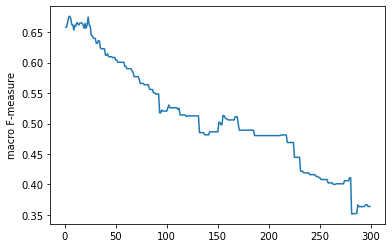

In [169]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)
plt.ylabel('macro F-measure')
plt.show(xs, ys)
